# NMT Homework (Self-Contained): EN→DE

Train a translation model (English→German), measure perplexity and BLEU, save a checkpoint, and optionally export predictions for ML‑Arena.

Focus: experiment with architectures (LSTM w/ attention, Transformer, decoding strategies) — not boilerplate. Core evaluation functions are provided to ensure consistent scoring across students.

Data: the course staff provides `dataset_splits/` in the repo root. No additional setup is needed for data.

## 0. Setup
Use `install.sh` or `pip install -r requirements.txt` to set up.

In [ ]:
MODEL_NR = [0, 1, 2][1]
print(f'You chose model {MODEL_NR} - LOL')

You chose model 1 - LOL


In [8]:
# !pip install -r requirements.txt
import torch
import sys
import os
import math
import random
from pathlib import Path

print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

try: 
    sys.stdout.reconfigure(line_buffering=True)
except Exception: 
    pass

PyTorch version: 2.8.0+cu128
Using device: cuda


In [9]:
HOME_DIR = Path(os.getcwd())
WORK_DIR = HOME_DIR / 'DLNLP25W'
if os.name == 'posix':
    # then create a folder named DLNLP25W
    # if folder exists then dont create it
    if not os.path.exists(WORK_DIR):
        os.makedirs(WORK_DIR)
    os.chdir(WORK_DIR)
print(os.listdir())

['checkpoints', 'DLNLP25W', 'submissions']


## 1. Shared Utilities (no external imports)
Tokenization, vocabulary, dataset, collate, and fixed evaluation (PPL, NLL, BLEU).

In [10]:
from typing import List, Tuple, Dict, Iterable
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import math
import random

def set_seed(seed: int = 42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

SPECIAL_TOKENS = {'pad': '<pad>', 'sos': '<sos>', 'eos': '<eos>', 'unk': '<unk>'}

def simple_tokenize(s: str) -> List[str]:
    return s.strip().lower().split()

def read_split(path: str) -> List[Tuple[List[str], List[str]]]:
    pairs: List[Tuple[List[str], List[str]]] = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.rstrip(' ').split('\t')
            if len(parts) < 2: 
                continue
            pairs.append((simple_tokenize(parts[0]), simple_tokenize(parts[1])))
    return pairs

def build_vocab(seqs: Iterable[List[str]], max_size: int | None = None) -> Dict[str, int]:
    from collections import Counter
    c = Counter()
    for s in seqs: 
        c.update(s)
    itms = c.most_common(max_size) if max_size else c.items()
    stoi = { # special tokens ids
        SPECIAL_TOKENS['pad']: 0, 
        SPECIAL_TOKENS['sos']: 1, 
        SPECIAL_TOKENS['eos']: 2, 
        SPECIAL_TOKENS['unk']: 3,
    }
    for w, _ in itms:
        if w not in stoi: 
            stoi[w] = len(stoi)
    return stoi

def encode(tokens: List[str], stoi: Dict[str, int], add_sos_eos: bool = False) -> List[int]:
    ids = [stoi.get(t, stoi[SPECIAL_TOKENS['unk']]) for t in tokens]
    if add_sos_eos: 
        ids = [stoi[SPECIAL_TOKENS['sos']]] + ids + [stoi[SPECIAL_TOKENS['eos']]]
    return ids

class Example:
    def __init__(self, s: List[int], ti: List[int], to: List[int]): 
        self.src_ids = s
        self.tgt_in_ids = ti
        self.tgt_out_ids = to

class TranslationDataset(Dataset):
    def __init__(self, pairs, src_stoi, tgt_stoi):
        self.examples: List[Example] = []
        for src, tgt in pairs:
            s = encode(src, src_stoi) + [src_stoi[SPECIAL_TOKENS['eos']]]
            t = encode(tgt, tgt_stoi, add_sos_eos=True)
            self.examples.append(Example(s, t[:-1], t[1:]))

    def __len__(self): 
        return len(self.examples)
    
    def __getitem__(self, i): 
        return self.examples[i]

def collate_pad(batch, pad_id_src: int, pad_id_tgt: int):
    src_max = max(len(x.src_ids) for x in batch)
    tgt_max = max(len(x.tgt_in_ids) for x in batch)
    
    def pad_to(a, L, pad):
        return a + [pad] * (L - len(a))
        
    src = torch.tensor([pad_to(x.src_ids, src_max, pad_id_src) for x in batch])
    tgt_in = torch.tensor([pad_to(x.tgt_in_ids, tgt_max, pad_id_tgt) for x in batch])
    tgt_out = torch.tensor([pad_to(x.tgt_out_ids, tgt_max, pad_id_tgt) for x in batch])
    src_l = torch.tensor([len(x.src_ids) for x in batch])
    tgt_l = torch.tensor([len(x.tgt_out_ids) for x in batch])
    return src, src_l, tgt_in, tgt_out, tgt_l

def compute_perplexity(loss_sum: float, token_count: int) -> float:
    if token_count == 0:
        return float('inf')
    try:
        return float(math.exp(loss_sum / token_count))
    except OverflowError:
        return float('inf')

def corpus_bleu(refs: List[List[str]], hyps: List[List[str]], max_order: int = 4, smooth: bool = True) -> float:
    from collections import Counter

    def ngrams(t, n):
        return Counter([tuple(t[i:i+n]) for i in range(len(t)-n+1)])

    m = [0] * max_order
    p = [0] * max_order
    rl = 0
    hl = 0

    for r, h in zip(refs, hyps):
        rl += len(r)
        hl += len(h)
        for n in range(1, max_order + 1):
            R = ngrams(r, n)
            H = ngrams(h, n)
            m[n-1] += sum(min(c, H[g]) for g, c in R.items())
            p[n-1] += max(len(h) - n + 1, 0)

    prec = [
        (m[i] + 1) / (p[i] + 1) if smooth else (m[i] / p[i] if p[i] > 0 else 0.0)
        for i in range(max_order)
    ]
    geo = math.exp(sum((1 / max_order) * math.log(x) for x in prec if x > 0)) if min(prec) > 0 else 0.0
    bp = 1.0 if hl > rl else math.exp(1 - rl / max(1, hl))
    return float(geo * bp)

@torch.no_grad()
def evaluate_nll(loader: DataLoader, model: nn.Module, pad_id_tgt: int, device: torch.device):
    '''Evaluation of negative log-likelihood loss on the given data loader.'''
    criterion = nn.CrossEntropyLoss(ignore_index=pad_id_tgt, reduction='sum')
    model.eval()
    tot = 0.0
    toks = 0
    for src, src_l, tgt_in, tgt_out, tgt_l in loader:
        src, src_l = src.to(device), src_l.to(device)
        tgt_in, tgt_out = tgt_in.to(device), tgt_out.to(device)
        logits = model(src, src_l, tgt_in)
        loss = criterion(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))
        tot += float(loss.item())
        toks += int((tgt_out != pad_id_tgt).sum().item())
    return tot, toks

@torch.no_grad()
def evaluate_bleu(loader: DataLoader, model: nn.Module, tgt_itos: List[str], sos_id: int, eos_id: int, device: torch.device, max_len: int = 100):
    '''BLEU score evaluation on the given data loader.'''
    model.eval()
    refs = []
    hyps = []
    for src, src_l, tgt_in, tgt_out, tgt_l in loader:
        src, src_l = src.to(device), src_l.to(device)
        pred = model.greedy_decode(
            src, src_l, max_len=max_len, sos_id=sos_id, eos_id=eos_id
        )
        for b in range(src.size(0)):
            ref_ids = tgt_out[b].tolist()
            hyp_ids = pred[b].tolist()
            if eos_id in ref_ids: 
                ref_ids = ref_ids[:ref_ids.index(eos_id)]
            if eos_id in hyp_ids: 
                hyp_ids = hyp_ids[:hyp_ids.index(eos_id)]
            refs.append([tgt_itos[i] for i in ref_ids if i != 0])
            hyps.append([tgt_itos[i] for i in hyp_ids if i != 0 and i != sos_id])
    return float(corpus_bleu(refs, hyps))

## 2. Paths and Hyperparameters

In [27]:
set_seed(42)

if not os.path.exists('../data'):
    import requests
    os.makedirs('../data', exist_ok=True)
    # downnload data
    for dataset in ['train', 'val', 'public_test',]:
        url = f'https://raw.githubusercontent.com/MarkusStefan/DLNLP25W/dev/data/{dataset}.txt'
        response = requests.get(url)
        lines = response.text.strip().split('\n')
        with open(f'../data/{dataset}.txt', 'w', encoding='utf-8') as f:
            for line in lines:
                f.write(line + '\n')
train_path = '../data/train.txt'
val_path = '../data/val.txt'
public_test_path = '../data/public_test.txt'

if not os.path.exists(public_test_path):
    alt = '../data/test_public.txt'
    public_test_path = alt if os.path.exists(alt) else public_test_path

private_test_path = '../data/private_test.txt'

src_vocab_size = 30000
tgt_vocab_size = 30000
emb_dim = 256
hid_dim = 512
layers = 3
dropout = 0.1
batch_size = 64
epochs = 10
lr = 5e-4
max_decode_len = 100

save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)
SAVE_DIR = os.path.join(save_dir, f'checkpoint_last_{MODEL_NR}.pt')
print('Public test path:', public_test_path)

Public test path: ../data/public_test.txt


## 3. Load Data and Build Vocab

In [28]:
print('Loading splits...')
train_pairs = read_split(train_path)
val_pairs = read_split(val_path)
test_pairs = read_split(public_test_path)
print(f'Train: {len(train_pairs):,} | Val: {len(val_pairs):,} | Public test: {len(test_pairs):,}')

src_stoi = build_vocab((s for s, _ in train_pairs), max_size=src_vocab_size)
tgt_stoi = build_vocab((t for _, t in train_pairs), max_size=tgt_vocab_size)

pad_id_src = src_stoi[SPECIAL_TOKENS['pad']]
pad_id_tgt = tgt_stoi[SPECIAL_TOKENS['pad']]
sos_id = tgt_stoi[SPECIAL_TOKENS['sos']]
eos_id = tgt_stoi[SPECIAL_TOKENS['eos']]

train_ds = TranslationDataset(train_pairs, src_stoi, tgt_stoi)
val_ds = TranslationDataset(val_pairs, src_stoi, tgt_stoi)
test_ds = TranslationDataset(test_pairs, src_stoi, tgt_stoi)

collate = lambda b: collate_pad(b, pad_id_src, pad_id_tgt)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate, num_workers=0)

tgt_itos = [None] * len(tgt_stoi)
for w, i in tgt_stoi.items():
    if 0 <= i < len(tgt_itos):
        tgt_itos[i] = w

print('Vocab sizes — src:', len(src_stoi), 'tgt:', len(tgt_stoi))

Loading splits...
Train: 226,997 | Val: 32,428 | Public test: 32,428
Train: 226,997 | Val: 32,428 | Public test: 32,428
Vocab sizes — src: 30004 tgt: 30004
Vocab sizes — src: 30004 tgt: 30004


## 4. Build Model (Your Playground)
Keep the forward/greedy_decode contract so evaluation works. Try adding attention, GRU, Transformer, etc.

In [29]:
if MODEL_NR == 0:
    class Encoder(nn.Module):
        def __init__(self, vocab_size, emb_dim, hid_dim, num_layers=1, dropout=0.1):
            super().__init__()
            self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
            self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)

        def forward(self, src, src_lens):
            emb = self.emb(src)
            packed = nn.utils.rnn.pack_padded_sequence(emb, src_lens.cpu(), batch_first=True, enforce_sorted=False)
            out, (h, c) = self.rnn(packed)
            out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
            return out, (h, c)

    class Decoder(nn.Module):
        def __init__(self, vocab_size, emb_dim, hid_dim, num_layers=1, dropout=0.1):
            super().__init__()
            self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
            self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
            self.proj = nn.Linear(hid_dim, vocab_size)

        def forward(self, tgt_in, hidden):
            emb = self.emb(tgt_in)
            out, hidden = self.rnn(emb, hidden)
            return self.proj(out), hidden

    class Seq2Seq(nn.Module):
        def __init__(self, enc, dec):
            super().__init__()
            self.encoder = enc
            self.decoder = dec

        def forward(self, src, src_lens, tgt_in):
            _, h = self.encoder(src, src_lens)
            logits, _ = self.decoder(tgt_in, h)
            return logits

        @torch.no_grad()
        def greedy_decode(self, src, src_lens, max_len, sos_id, eos_id):
            B = src.size(0)
            _, h = self.encoder(src, src_lens)
            inputs = torch.full((B, 1), sos_id, dtype=torch.long, device=src.device)
            outs = []
            for _ in range(max_len):
                logits, h = self.decoder(inputs[:, -1:].contiguous(), h)
                nxt = logits[:, -1, :].argmax(-1, keepdim=True)
                outs.append(nxt)
                inputs = torch.cat([inputs, nxt], dim=1)
            
            seqs = torch.cat(outs, dim=1)
            for i in range(B):
                row = seqs[i]
                if (row == eos_id).any():
                    idx = (row == eos_id).nonzero(as_tuple=False)[0].item()
                    row[idx + 1:] = eos_id
            return seqs

In [30]:
# MODEL 1: Using GRU, torch.float16 and 
if MODEL_NR == 1:
    class Encoder(nn.Module):
        def __init__(self, vocab_size, emb_dim, hid_dim, num_layers=2, dropout=0.1):
            super().__init__()
            self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
            self.rnn = nn.GRU(emb_dim, hid_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 0 else 0.0)

        def forward(self, src, src_lens):
            emb = self.emb(src)
            packed = nn.utils.rnn.pack_padded_sequence(emb, src_lens.cpu(), batch_first=True, enforce_sorted=False)
            out, h = self.rnn(packed)
            out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
            return out, h


    class Decoder(nn.Module):
        def __init__(self, vocab_size, emb_dim, hid_dim, num_layers=1, dropout=0.1):
            super().__init__()
            self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
            self.rnn = nn.GRU(emb_dim, hid_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 0 else 0.0)
            self.fc1 = nn.Linear(hid_dim, vocab_size)

        def forward(self, tgt_in, hidden):
            emb = self.emb(tgt_in)
            # Now hidden state matches the layer structure correctly
            out, hidden = self.rnn(emb, hidden)
            return self.fc1(out), hidden


    class Seq2Seq(nn.Module):
        def __init__(self, enc, dec):
            super().__init__()
            self.encoder = enc
            self.decoder = dec

        def forward(self, src, src_lens, tgt_in):
            _, h = self.encoder(src, src_lens)
            logits, _ = self.decoder(tgt_in, h)
            return logits

        @torch.no_grad()
        def greedy_decode(self, src, src_lens, max_len, sos_id, eos_id):
            B = src.size(0)
            _, h = self.encoder(src, src_lens)
            inputs = torch.full((B, 1), sos_id, dtype=torch.long, device=src.device)
            outs = []
            for _ in range(max_len):
                logits, h = self.decoder(inputs[:, -1:].contiguous(), h)
                nxt = logits[:, -1, :].argmax(-1, keepdim=True)
                outs.append(nxt)
                inputs = torch.cat([inputs, nxt], dim=1)
            
            seqs = torch.cat(outs, dim=1)
            for i in range(B):
                row = seqs[i]
                if (row == eos_id).any():
                    idx = (row == eos_id).nonzero(as_tuple=False)[0].item()
                    row[idx + 1:] = eos_id
            return seqs

In [31]:
# MODEL 2: Using GRU, torch.float16, and student-teacher training based on fine-tuned BERT
if MODEL_NR == 2:
    import transformers
    from transformers import EncoderDecoderModel
    import torch.nn.functional as F

    print("Loading Teacher Model (Pre-trained BERT2BERT)...")
    teacher_name = "google/bert2bert_L-24_wmt_en_de"
    teacher_model = EncoderDecoderModel.from_pretrained(teacher_name).to(device)
    teacher_model.eval()
    for param in teacher_model.parameters():
        param.requires_grad = False
        
    print("Teacher loaded and frozen.")

    class Encoder(nn.Module):
        def __init__(self, vocab_size, emb_dim, hid_dim, num_layers=1, dropout=0.1):
            super().__init__()
            self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_id_src)
            self.rnn = nn.GRU(emb_dim, hid_dim, num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0.0)
            self.fc = nn.Linear(hid_dim * 2, hid_dim)

        def forward(self, src, src_lens):
            emb = self.emb(src)
            packed = nn.utils.rnn.pack_padded_sequence(emb, src_lens.cpu(), batch_first=True, enforce_sorted=False)
            outputs, hidden = self.rnn(packed)
            outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
            
            hidden_cat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
            hidden = torch.tanh(self.fc(hidden_cat))
            
            return outputs, hidden

    class Attention(nn.Module):
        def __init__(self, hid_dim):
            super().__init__()
            self.attn = nn.Linear(hid_dim * 3, hid_dim)
            self.v = nn.Linear(hid_dim, 1, bias=False)

        def forward(self, hidden, encoder_outputs):
            src_len = encoder_outputs.shape[1]
            hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
            energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
            attention = self.v(energy).squeeze(2)
            return F.softmax(attention, dim=1)

    class Decoder(nn.Module):
        def __init__(self, vocab_size, emb_dim, hid_dim, num_layers=1, dropout=0.1):
            super().__init__()
            self.attention = Attention(hid_dim)
            self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_id_tgt)
            self.rnn = nn.GRU(hid_dim * 2 + emb_dim, hid_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
            self.fc_out = nn.Linear(hid_dim + emb_dim + hid_dim * 2, vocab_size)
            self.dropout = nn.Dropout(dropout)

        def forward(self, input, hidden, encoder_outputs):
            input = input.unsqueeze(1)
            embedded = self.dropout(self.emb(input))
            
            a = self.attention(hidden[-1], encoder_outputs)
            a = a.unsqueeze(1)
            
            weighted = torch.bmm(a, encoder_outputs)
            
            rnn_input = torch.cat((embedded, weighted), dim=2)
            
            output, hidden = self.rnn(rnn_input, hidden)
            
            embedded = embedded.squeeze(1)
            output = output.squeeze(1)
            weighted = weighted.squeeze(1)
            
            prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
            
            return prediction, hidden

    class Seq2Seq(nn.Module):
        def __init__(self, enc, dec):
            super().__init__()
            self.encoder = enc
            self.decoder = dec

        def forward(self, src, src_lens, tgt_in):
            batch_size = src.shape[0]
            tgt_len = tgt_in.shape[1]
            vocab_size = self.decoder.fc_out.out_features
            device = src.device
            
            encoder_outputs, hidden = self.encoder(src, src_lens)
            
            # Prepare hidden for decoder (num_layers)
            num_layers = self.decoder.rnn.num_layers
            hidden = hidden.unsqueeze(0).repeat(num_layers, 1, 1)
            
            outputs = torch.zeros(batch_size, tgt_len, vocab_size).to(device)
            
            for t in range(tgt_len):
                output, hidden = self.decoder(tgt_in[:, t], hidden, encoder_outputs)
                outputs[:, t] = output
            
            return outputs

        @torch.no_grad()
        def greedy_decode(self, src, src_lens, max_len, sos_id, eos_id):
            batch_size = src.shape[0]
            device = src.device
            encoder_outputs, hidden = self.encoder(src, src_lens)
            
            num_layers = self.decoder.rnn.num_layers
            hidden = hidden.unsqueeze(0).repeat(num_layers, 1, 1)
            
            inputs = torch.tensor([sos_id] * batch_size).to(device)
            outs = []
            
            for _ in range(max_len):
                output, hidden = self.decoder(inputs, hidden, encoder_outputs)
                pred = output.argmax(1)
                outs.append(pred.unsqueeze(1))
                inputs = pred
            
            seqs = torch.cat(outs, dim=1)
            return seqs

In [32]:
encoder = Encoder(len(src_stoi), emb_dim, hid_dim, num_layers=layers, dropout=dropout)
decoder = Decoder(len(tgt_stoi), emb_dim, hid_dim, num_layers=layers, dropout=dropout)
model = Seq2Seq(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print("Nr of params:\t", sum(p.numel() for p in model.parameters() if p.requires_grad))

Nr of params:	 39423284


## 5. Train

In [33]:
from tqdm import tqdm
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss(ignore_index=pad_id_tgt, reduction='sum')
evals = {
    'train_loss': [],
    'val_loss': [],
    'train_perplexity': [],
    'val_perplexity': [],
    'train_nll': [],
    'val_nll': [],

}
best_model = None
best_val_ppl = float('inf')
with tqdm(total=epochs) as pbar:
    for epoch in range(epochs):
        model.train()
        tot = 0.0
        toks = 0
        n_samples = train_loader.dataset.__len__()
        n_samples_seen = 0
        for src, src_l, tgt_in, tgt_out, tgt_l in train_loader:
            src, src_l = src.to(device), src_l.to(device)
            tgt_in, tgt_out = tgt_in.to(device), tgt_out.to(device)
            
            optimizer.zero_grad()
            logits = model(src, src_l, tgt_in)
            loss = criterion(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))
            
            if MODEL_NR == 2:
                # Distillation
                with torch.no_grad():
                    src_mask = (src != pad_id_src).long()
                    teacher_out = teacher_model(input_ids=src, attention_mask=src_mask, decoder_input_ids=tgt_in)
                    teacher_logits = teacher_out.logits
                
                T = 2.0
                alpha = 0.5
                
                student_logits_flat = logits.reshape(-1, logits.size(-1))
                teacher_logits_flat = teacher_logits.reshape(-1, teacher_logits.size(-1))
                target_flat = tgt_out.reshape(-1)
                
                mask = (target_flat != pad_id_tgt)
                
                if mask.sum() > 0:
                    loss_kd = nn.KLDivLoss(reduction='batchmean')(
                        F.log_softmax(student_logits_flat[mask] / T, dim=-1),
                        F.softmax(teacher_logits_flat[mask] / T, dim=-1)
                    ) * (T * T)
                    
                    # Combine losses (loss is sum, loss_kd is mean, need to balance?)
                    # criterion is reduction='sum'.
                    # loss_kd is reduction='batchmean' (average over batch, but here masked).
                    # We should probably normalize 'loss' by token count to match scale, or scale up loss_kd.
                    # Let's normalize 'loss' to be mean per token for combination, then scale back?
                    # Or just use a weighted sum where alpha handles the scale difference?
                    # CE sum is large. KL mean is small.
                    # Let's use CE mean for combination.
                    
                    loss_ce_mean = loss / mask.sum()
                    combined_loss = alpha * loss_ce_mean + (1 - alpha) * loss_kd
                    
                    # We need to backward the combined loss.
                    # But 'tot' tracks sum of CE loss for PPL calculation.
                    # So we keep 'loss' (sum) for 'tot', but backward 'combined_loss'.
                    
                    combined_loss.backward()
                else:
                    loss.backward()
            else:
                loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            tot += float(loss.item()) # This tracks CE sum (if MODEL_NR!=2) or CE sum (if MODEL_NR==2, wait)
            # If MODEL_NR==2, loss is still the CE sum tensor (before backward).
            # So tot is correct for PPL.
            
            toks += int((tgt_out != pad_id_tgt).sum().item())
            n_samples_seen += src.size(0)
            pbar.set_postfix(
                train_loss=f'{tot / toks if toks > 0 else float("inf"):.2f}', 
                epoch_pct=f'{(n_samples_seen / n_samples) * 100:.2f}', 
                overall_train_pct=f'{(epoch * n_samples + n_samples_seen) / (epochs * n_samples) * 100:.2f}'
            )
            
        tr_ppl = compute_perplexity(tot, toks)
        v_loss, v_toks = evaluate_nll(val_loader, model, pad_id_tgt, device)
        v_ppl = compute_perplexity(v_loss, v_toks)

        if v_ppl < best_val_ppl:
            best_val_ppl = v_ppl
            best_model = model.state_dict()

        # update tqdm summary metrics
        pbar.set_postfix(train_ppl=f'{tr_ppl:.2f}', val_ppl=f'{v_ppl:.2f}')
        pbar.update(1)

torch.save({
    'model_state': best_model,
    'optimizer_state': optimizer.state_dict(),
    'epoch': epochs,
    'src_stoi': src_stoi,
    'tgt_stoi': tgt_stoi,
    'model_cfg': {'emb': emb_dim, 'hid': hid_dim, 'layers': layers, 'dropout': dropout}
}, SAVE_DIR)

print('Saved checkpoint:', SAVE_DIR)

  0%|          | 0/10 [00:04<?, ?it/s, epoch_pct=4.60, overall_train_pct=0.46, train_loss=6.46] 



KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm

criterion = nn.CrossEntropyLoss(ignore_index=pad_id_tgt, reduction='sum')
evals = {
    'train_loss': [],
    'val_loss': [],
    'train_perplexity': [],
    'val_perplexity': [],
    'train_nll': [],
    'val_nll': [],

}
best_model = None
best_val_ppl = float('inf')
best_epoch = 0
with tqdm(total=epochs) as pbar:
    for epoch in range(epochs):
        model.train()
        tot = 0.0
        toks = 0
        n_samples = train_loader.dataset.__len__()
        n_samples_seen = 0
        for src, src_l, tgt_in, tgt_out, tgt_l in train_loader:
            src, src_l = src.to(device), src_l.to(device)
            tgt_in, tgt_out = tgt_in.to(device), tgt_out.to(device)
            
            optimizer.zero_grad()
            logits = model(src, src_l, tgt_in)
            loss = criterion(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            tot += float(loss.item())
            toks += int((tgt_out != pad_id_tgt).sum().item())
            n_samples_seen += src.size(0)
            avg_loss = tot / toks if toks > 0 else float("inf")
            pbar.set_postfix(
                train_loss=f'{avg_loss:.2f}', 
                epoch_pct=f'{(n_samples_seen / n_samples) * 100:.2f}', 
                overall_train_pct=f'{(epoch * n_samples + n_samples_seen) / (epochs * n_samples) * 100:.2f}',
                best_perplexity_epoch=best_epoch+1
            )
            
        tr_ppl = compute_perplexity(tot, toks)
        v_loss, v_toks = evaluate_nll(val_loader, model, pad_id_tgt, device)
        v_ppl = compute_perplexity(v_loss, v_toks)

        evals['train_loss'].append(avg_loss)
        evals['val_loss'].append(v_loss / v_toks)
        evals['train_perplexity'].append(tr_ppl)
        evals['val_perplexity'].append(v_ppl)
        # evals['train_nll'].append(...)
        # evals['val_nll'].append(...)
        if v_ppl < best_val_ppl:
            best_val_ppl = v_ppl
            best_model = model.state_dict()
            best_epoch = epoch + 1

        # update tqdm summary metrics
        pbar.set_postfix(train_ppl=f'{tr_ppl:.2f}', val_ppl=f'{v_ppl:.2f}')
        pbar.update(1)

torch.save({
    'model_state': best_model,
    'optimizer_state': optimizer.state_dict(),
    'epoch': epochs,
    'src_stoi': src_stoi,
    'tgt_stoi': tgt_stoi,
    'model_cfg': {'emb': emb_dim, 'hid': hid_dim, 'layers': layers, 'dropout': dropout}
}, SAVE_DIR)

print('Saved checkpoint:', SAVE_DIR)

100%|██████████| 10/10 [15:37<00:00, 93.76s/it, train_ppl=1.80, val_ppl=5.77]                                                       



Saved checkpoint: checkpoints/checkpoint_last_1.pt


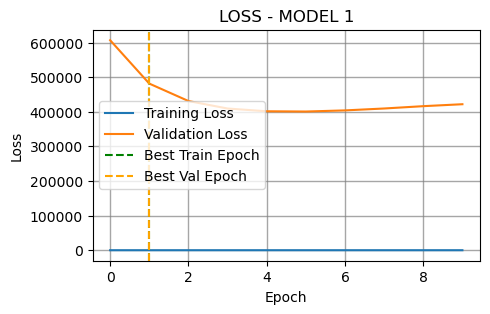

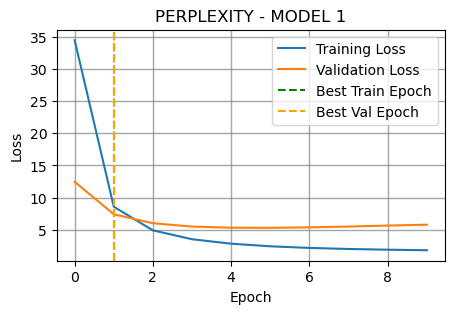

In [39]:
# plot losses
import matplotlib.pyplot as plt
import numpy as np

def plot_loss(train_loss_history=None, val_loss_history=None, best_train_epoch=None, best_val_epoch=None, title=None):
    '''Plotting utility for training/validation loss curves.'''
    plt.figure(figsize=(5, 3))
    assert train_loss_history is not None or val_loss_history is not None, "At least one loss history must be provided."
    if train_loss_history is not None:
        plt.plot(train_loss_history, label='Training Loss')
    if val_loss_history is not None:
        plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title if title is not None else 'Loss over Epochs')
    if best_train_epoch is not None:
        plt.axvline(x=best_train_epoch, color='green', linestyle='--', label='Best Train Epoch')
    if best_val_epoch is not None:
        plt.axvline(x=best_val_epoch, color='orange', linestyle='--', label='Best Val Epoch')
    # ensure x axis ticks are discrete, only plot every second tick if too many epochs
    if len(train_loss_history) > 10:
        plt.xticks(ticks=np.arange(0, len(train_loss_history), 2), labels=np.arange(0, len(train_loss_history), 2))
    plt.legend()
    plt.grid(color='gray', alpha=0.7, linewidth=1)
    plt.show()


plot_loss(evals.get('train_loss'), evals.get('val_loss'), best_train_epoch = 1, best_val_epoch = 1, title = f'LOSS - MODEL {MODEL_NR}')
plot_loss(evals.get('train_perplexity'), evals.get('val_perplexity'), best_train_epoch = 1, best_val_epoch = 1, title = f'PERPLEXITY - MODEL {MODEL_NR}')

## 6. Evaluate: Perplexity and BLEU (Public Test)

BLEU score:
$$
  B(\hat{y}, y) = \beta \cdot \exp\left(\sum_{i=1}^N w_i \cdot \ln(p_i)\right)
$$


In [40]:
val_loss, val_tok = evaluate_nll(val_loader, model, pad_id_tgt, device)
val_ppl = compute_perplexity(val_loss, val_tok)

tst_loss, tst_tok = evaluate_nll(test_loader, model, pad_id_tgt, device)
tst_ppl = compute_perplexity(tst_loss, tst_tok)

val_bleu = evaluate_bleu(val_loader, model, tgt_itos, sos_id=sos_id, eos_id=eos_id, device=device, max_len=max_decode_len)
bleu = evaluate_bleu(test_loader, model, tgt_itos, sos_id=sos_id, eos_id=eos_id, device=device, max_len=max_decode_len)

print(f'Validation loss:        {val_loss / val_tok:.2f}')
print(f'Validation perplexity:  {val_ppl:.2f}')
print(f'Public test perplexity: {tst_ppl:.2f}')
print(f'Validation BLEU:        {val_bleu * 100:.2f}')
print(f'Public test BLEU:       {bleu * 100:.2f}')

Validation loss:        1.75
Validation perplexity:  5.77
Public test perplexity: 5.70
Validation BLEU:        31.22
Public test BLEU:       31.25


## 7. Private Test (Optional)

In [37]:
if os.path.exists(private_test_path):
    prv_pairs = read_split(private_test_path)
    prv_ds = TranslationDataset(prv_pairs, src_stoi, tgt_stoi)
    prv_loader = DataLoader(prv_ds, batch_size=batch_size, shuffle=False, collate_fn=collate, num_workers=0)
    
    prv_loss, prv_tok = evaluate_nll(prv_loader, model, pad_id_tgt, device)
    prv_ppl = compute_perplexity(prv_loss, prv_tok)
    
    prv_bleu = evaluate_bleu(prv_loader, model, tgt_itos, sos_id=sos_id, eos_id=eos_id, device=device, max_len=max_decode_len)
    
    print(f'Private test perplexity: {prv_ppl:.2f}')
    print(f'Private test BLEU:       {prv_bleu * 100:.2f}')
else:
    print('Private test split not found at', private_test_path)

Private test split not found at ../data/private_test.txt


## 8. Export Predictions for ML‑Arena (Optional)

In [38]:
@torch.no_grad()
def decode_to_lines(loader: DataLoader, model: nn.Module, tgt_itos: List[str], sos_id: int, eos_id: int, device: torch.device, max_len: int) -> List[str]:
    lines: List[str] = []
    for src, src_l, tgt_in, tgt_out, tgt_l in loader:
        src, src_l = src.to(device), src_l.to(device)
        pred_ids = model.greedy_decode(src, src_l, max_len=max_len, sos_id=sos_id, eos_id=eos_id)
        for b in range(src.size(0)):
            hyp = pred_ids[b].tolist()
            if eos_id in hyp:
                hyp = hyp[:hyp.index(eos_id)]
            toks = [tgt_itos[i] for i in hyp if i != 0 and i != sos_id]
            lines.append(' '.join(toks))
    return lines

# export_split = 'private'
export_split = 'public'
export_format = 'tsv'
export_out = 'submissions/private_predictions.tsv'

os.makedirs(os.path.dirname(export_out) or '.', exist_ok=True)
pairs = read_split(public_test_path if export_split == 'public' else private_test_path)
exp_ds = TranslationDataset(pairs, src_stoi, tgt_stoi)
exp_loader = DataLoader(exp_ds, batch_size=batch_size, shuffle=False, collate_fn=collate, num_workers=0)

preds = decode_to_lines(exp_loader, model, tgt_itos, sos_id=sos_id, eos_id=eos_id, device=device, max_len=max_decode_len)

if export_format == 'tsv':
    with open(export_out, 'w', encoding='utf-8') as f:
        for i, h in enumerate(preds):
            f.write(f'{i}\t{h}\n')
elif export_format == 'jsonl':
    import json
    with open(export_out, 'w', encoding='utf-8') as f:
        for i, h in enumerate(preds):
            f.write(json.dumps({'id': i, 'hyp': h}, ensure_ascii=False) + '\n')

print(f'Wrote {len(preds)} predictions to {export_out}')
print('Adjust if ML‑Arena requires a different schema.')

Wrote 32428 predictions to submissions/private_predictions.tsv
Adjust if ML‑Arena requires a different schema.
